# Data loading

We start by importing the packages and data.

In [21]:
%matplotlib inline
import scanpy.preprocessing
import scanpy.plotting
import scanpy.tools
import matplotlib.pyplot as plt
import scipy.stats
import pandas
import numpy
import sklearn.discriminant_analysis

adata = scanpy.read_h5ad("../../Data/all_data.h5ad")

We make a quick heatmap to check whether the data looks sensible:

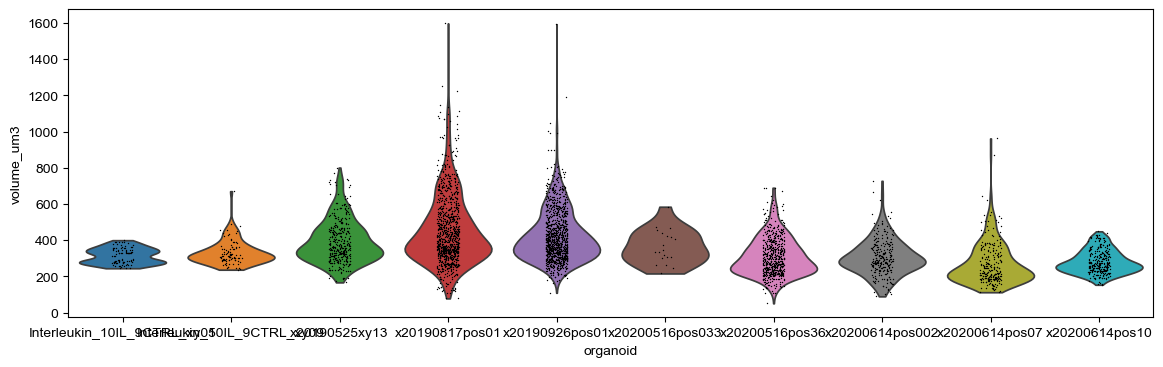

In [22]:
figure = plt.figure(figsize=(14, 4))
ax = figure.gca()
scanpy.plotting.violin(adata,
                       ax=ax,
                       keys=["volume_um3"], 
                       groupby="organoid")

We filter out cells with a suspiciously low or high volume: (indicating missegmentation)

In [23]:
adata = adata[adata[: , 'volume_um3'].X > 200, :]
adata = adata[adata[: , 'volume_um3'].X < 400, :]

We also filter to remove cells without a cell type:

In [24]:
adata = adata[adata.obs["cell_type_training"] != "NONE"]

# Start of analysis

Now we normalize the data:

In [25]:
scanpy.preprocessing.log1p(adata)
scanpy.preprocessing.scale(adata)

d:\miniconda\envs\organoid_tracker\lib\site-packages\scanpy\preprocessing\_simple.py:405: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


We also define a cell type palette that we will use everywhere:

In [26]:
cell_type_palette = {
    "ENTEROCYTE": "#100069",
    "OTHER_DIFFERENTIATED": "#100069",
    "ABSORPTIVE_PROGENY": "#0984e3",
    "SECRETORY": "#74b9ff",
    "ENTEROENDOCRINE": "#74b9ff",
    "GOBLET": "#74b9ff",
    "MATURE_GOBLET": "#74b9ff",
    "SECRETIVE_PROGENY": "#74b9ff",
    "WGA_PLUS": "#74b9ff",
    "OTHER_SECETORY": "#74b9ff",
    "PANETH": "#B60101",
    "STEM": "#26CC3C",
    "STEM_PUTATIVE": "#26CC3C",
    "UNLABELED": "#eeeeee",
    "TA": "#eeeeee",
    "NONE": "#ffffff"
}

Next, we plot the highly variable "genes" (or actually, nucleus parameters.)

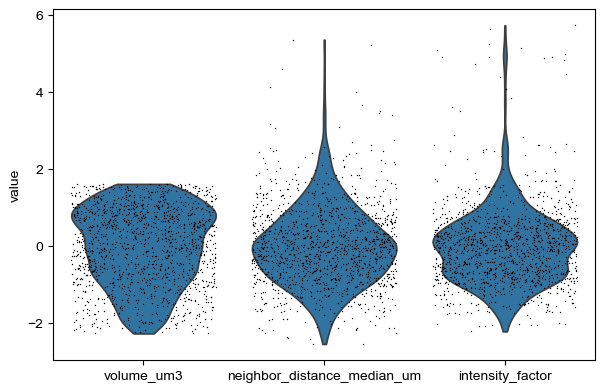

In [27]:

scanpy.plotting.violin(adata, ['volume_um3', 'neighbor_distance_median_um', 'intensity_factor'],
             jitter=0.4)


Next, we perform and plot the PCA:

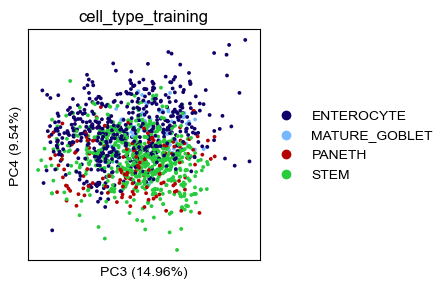

In [28]:
scanpy.tools.pca(adata, svd_solver='arpack')
fig = plt.figure(figsize=(3, 3))
scanpy.plotting.pca(adata, ax=fig.gca(), annotate_var_explained=True, color="cell_type_training", palette=cell_type_palette, show=False, s=30, linewidth=0,
                    dimensions=[(2,3)])
plt.show()

And one colored by organoid:

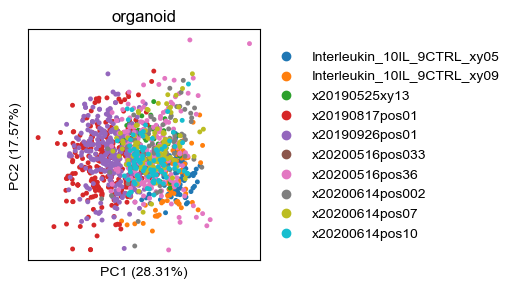

In [29]:
scanpy.tools.pca(adata, svd_solver='arpack')
fig = plt.figure(figsize=(3, 3))
scanpy.plotting.pca(adata, ax=fig.gca(), annotate_var_explained=True, color="organoid", show=False, s=50, linewidth=0,
                    dimensions=[(0,1)])
plt.show()

And show the elbow plot:

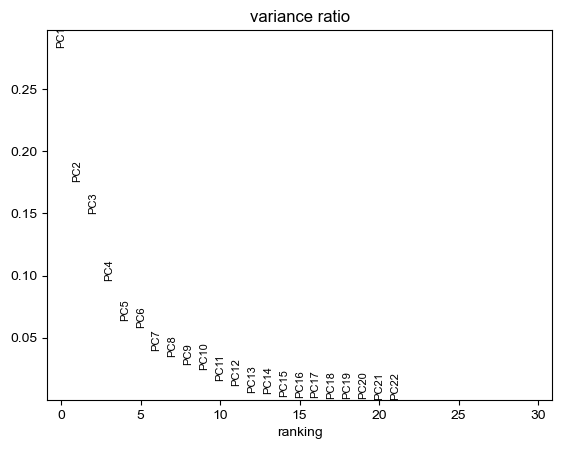

In [30]:
scanpy.plotting.pca_variance_ratio(adata, log=False)

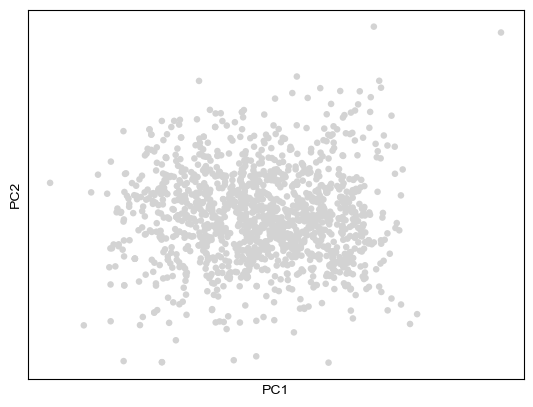

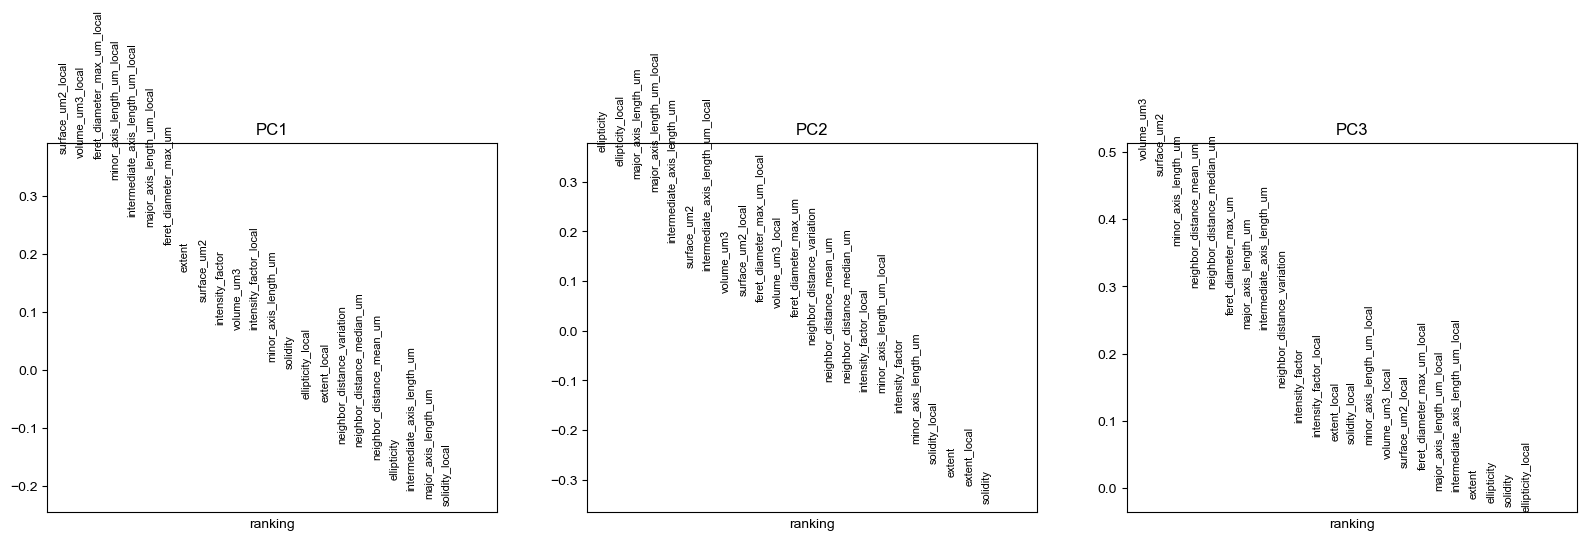

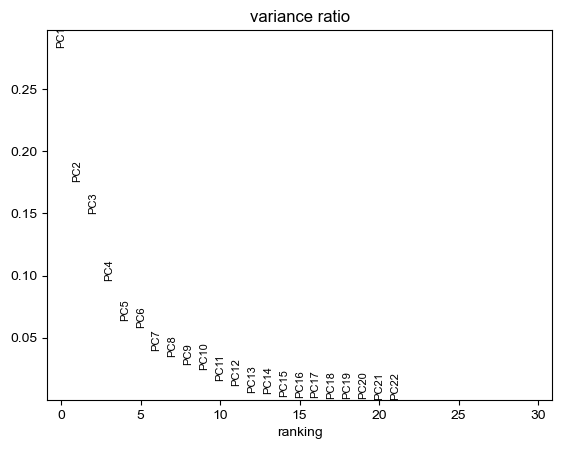

In [31]:
scanpy.plotting.pca_overview(adata)

# LDA plot

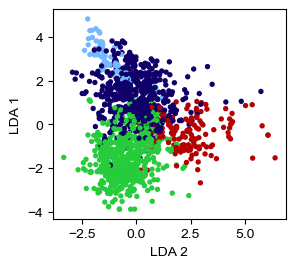

In [32]:
lda = sklearn.discriminant_analysis.LinearDiscriminantAnalysis()
plot_coords = lda.fit(adata.X, adata.obs["cell_type_training"]).transform(adata.X)

fig = plt.figure(figsize=(3, 4))
ax = fig.gca()

dimensions = (1, 0)
ax.scatter(plot_coords[:, dimensions[0]], plot_coords[:, dimensions[1]],
           alpha=1, s=15, lw=0,
           color=[cell_type_palette[adata.obs["cell_type_training"].iloc[i]] for i in range(len(adata.obs["cell_type_training"]))])
ax.set_xlabel(f"LDA {dimensions[0] + 1}")
ax.set_ylabel(f"LDA {dimensions[1] + 1}")
ax.set_aspect(1)
plt.show()

# UMAP clustering
Do UMAP clustering:

In [33]:
scanpy.preprocessing.neighbors(adata, n_pcs=10)
scanpy.tools.umap(adata)


And make some plots out of it:

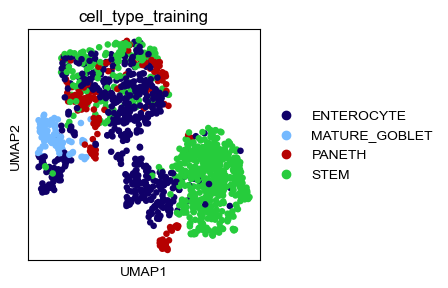

In [34]:
fig = plt.figure(figsize=(3, 3))
scanpy.plotting.umap(adata, color="cell_type_training", ax=fig.gca(), palette=cell_type_palette)

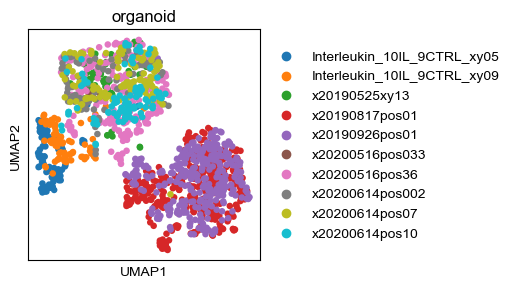

In [35]:
fig = plt.figure(figsize=(3, 3))
scanpy.plotting.umap(adata, color="organoid", ax=fig.gca())

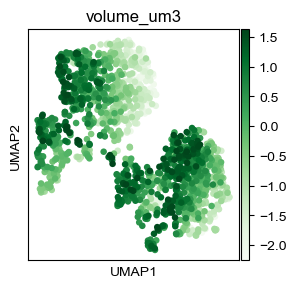

In [36]:
fig = plt.figure(figsize=(3, 3))
scanpy.plotting.umap(adata, color="volume_um3", color_map="Greens", ax=fig.gca())

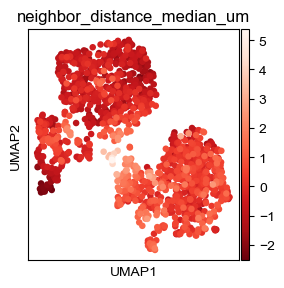

In [37]:
fig = plt.figure(figsize=(3, 3))
scanpy.plotting.umap(adata, color="neighbor_distance_median_um", color_map="Reds_r", ax=fig.gca())

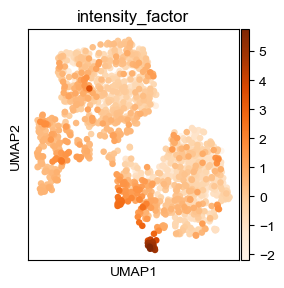

In [38]:
fig = plt.figure(figsize=(3, 3))
scanpy.plotting.umap(adata, color="intensity_factor", color_map="Oranges", ax=fig.gca())

# Most important variables for each cell type

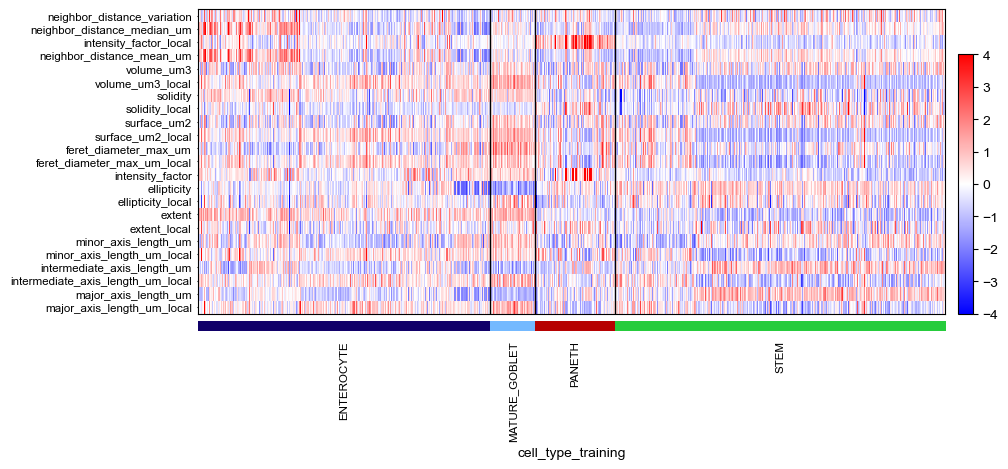

In [42]:
scanpy.plotting.heatmap(adata,
                        var_names=adata.var_names, 
                        groupby="cell_type_training", 
                        cmap="bwr", 
                        swap_axes=True, 
                        vmin=-4,
                        vmax=4,
                        save="heatmap.svg")


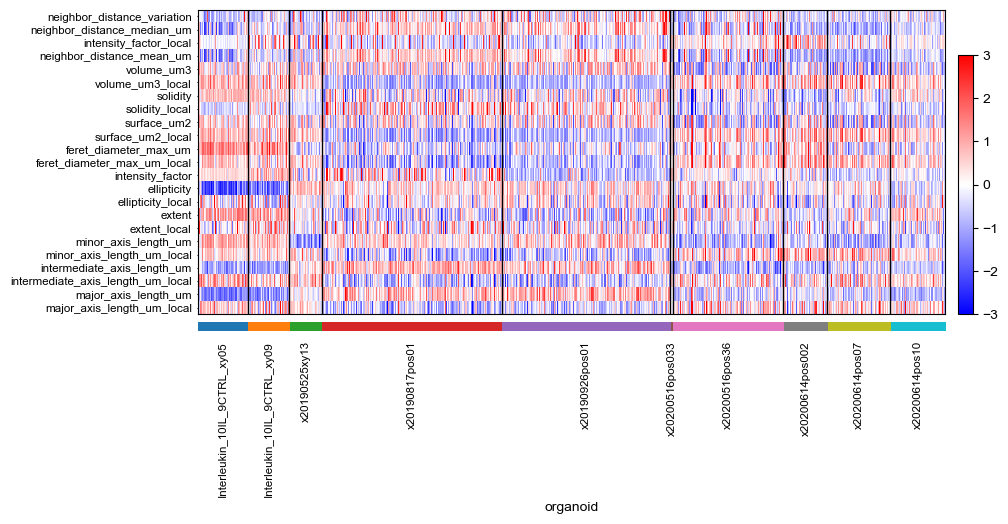

In [40]:
scanpy.plotting.heatmap(adata,
                        var_names=adata.var_names, 
                        groupby="organoid", 
                        cmap="bwr", 
                        swap_axes=True, 
                        vmin=-3,
                        vmax=3,
                        save="heatmap.svg")

d:\miniconda\envs\organoid_tracker\lib\site-packages\scanpy\tools\_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
d:\miniconda\envs\organoid_tracker\lib\site-packages\scanpy\tools\_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
d:\miniconda\envs\organoid_tracker\lib\site-packages\scanpy\tools\_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
d:\miniconda\envs\organoid_tracker\lib\site-packages\scanpy\tools\_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


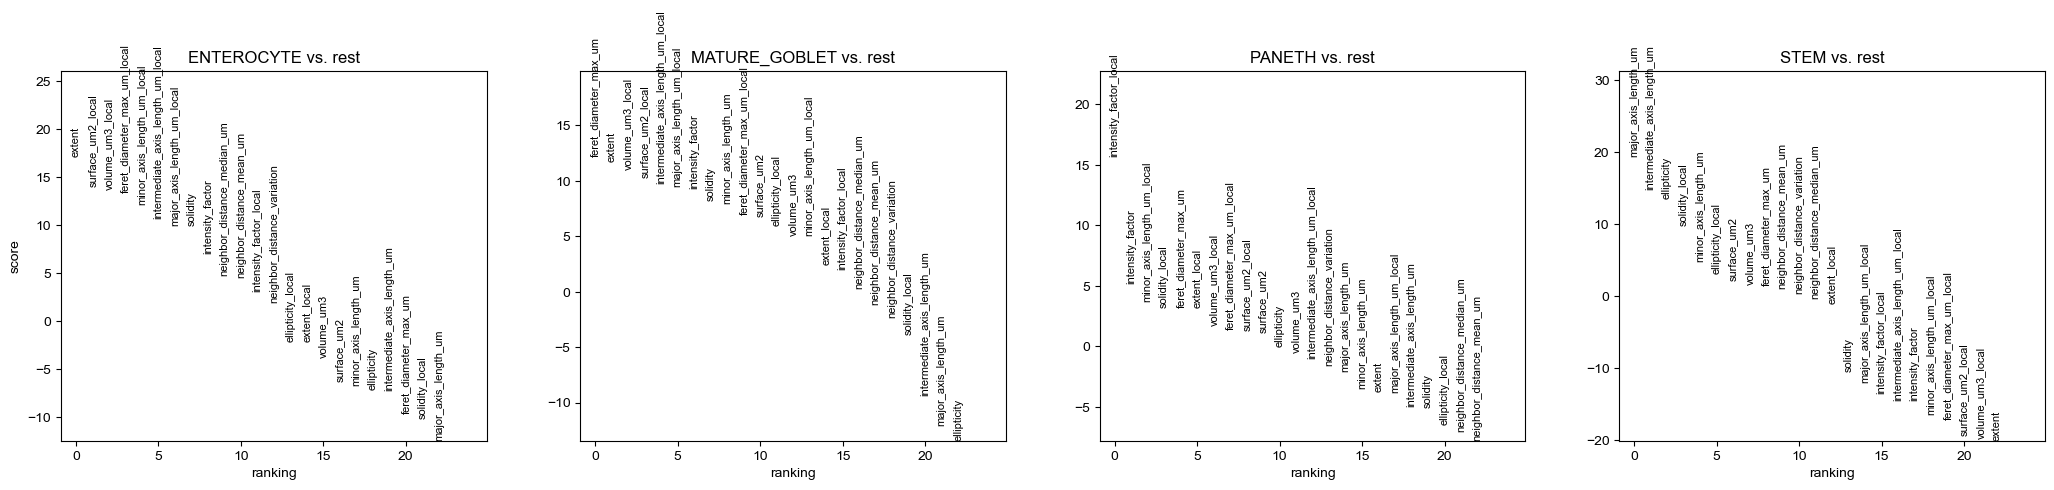

In [78]:
scanpy.tools.rank_genes_groups(adata, 'cell_type_training', method='wilcoxon')
scanpy.plotting.rank_genes_groups(adata, n_genes=25, sharey=False)

Define a p-adjust function:

In [48]:
def p_adjust_benjamini_hochberg(p_values):
    """Benjamini-Hochberg p-value correction for multiple hypothesis testing."""
    p_values = numpy.array(p_values)
    by_descend = p_values.argsort()[::-1]
    by_orig = by_descend.argsort()
    steps = float(len(p_values)) / numpy.arange(len(p_values), 0, -1)
    q_values = numpy.minimum(1, numpy.minimum.accumulate(steps * p_values[by_descend]))
    return q_values[by_orig]

In [50]:
# Use Anova to find variables that are significantly different among groups
groups_by_type = adata.obs.groupby("cell_type_training", observed=False).indices

rows = list()
for i, var_name in enumerate(adata.var_names):
    values_by_cell_type = list()
    for cell_type, indices in groups_by_type.items():
        values_by_cell_type.append(adata.X[indices, i])
    f_stat, p_value = scipy.stats.f_oneway(*values_by_cell_type)
    rows.append((var_name, p_value))

data_frame = pandas.DataFrame(rows, columns=["var_name", "p_value"]).sort_values("p_value")

# Adjust the p values
data_frame["p_value"] = p_adjust_benjamini_hochberg(data_frame["p_value"])

print(data_frame)


                             var_name        p_value
15                             extent  2.123268e-158
2              intensity_factor_local  1.701634e-130
21               major_axis_length_um  1.962465e-118
5                    volume_um3_local  1.543668e-110
9                   surface_um2_local  2.356242e-107
11        feret_diameter_max_um_local   2.132728e-75
13                        ellipticity   9.498679e-72
20  intermediate_axis_length_um_local   9.452006e-68
19        intermediate_axis_length_um   1.925517e-66
18         minor_axis_length_um_local   1.763088e-65
12                   intensity_factor   3.215109e-57
22         major_axis_length_um_local   1.782953e-56
6                            solidity   4.388555e-42
10              feret_diameter_max_um   1.693526e-39
7                      solidity_local   7.988025e-33
14                  ellipticity_local   5.947499e-19
17               minor_axis_length_um   3.784849e-15
8                         surface_um2   4.9514

In [51]:
most_important_variables = list(data_frame["var_name"][0:10])
print(most_important_variables)

['extent', 'intensity_factor_local', 'major_axis_length_um', 'volume_um3_local', 'surface_um2_local', 'feret_diameter_max_um_local', 'ellipticity', 'intermediate_axis_length_um_local', 'intermediate_axis_length_um', 'minor_axis_length_um_local']
